# Random Forest Classifier

## Get dataset

In [1]:
import finlab.ml as ml

dataset = ml.fundamental_features()

print(dataset.shape)
dataset = dataset.dropna(thresh=int(len(dataset)*0.5), axis=1).dropna(how='any')
print(dataset.shape)

(44675, 41)
(17342, 41)


## Add labels

In [2]:
feature_names = list(dataset.columns)

In [3]:
ml.add_profit_prediction(dataset)
dataset.head()

R101_ROA稅後息前  R11V_ROA綜合損益  R103_ROE稅後  R11U_ROE綜合損益  \
stock_id date                                                               
1101     2014-05-15  2.791232e+06      1.630076    1.789978      2.971092   
         2014-08-14  8.379538e+06      0.152556    5.481276      0.282596   
         2014-11-14  1.477153e+07      2.168353    9.817990      4.058708   
         2015-03-31  1.996292e+07      3.002608   12.657647      5.476992   
         2015-05-15  9.745154e+05      0.069454    0.601114      0.124782   

                     R145_稅前息前折舊前淨利率  R105_營業毛利率  R106_營業利益率  R107_稅前淨利率  \
stock_id date                                                              
1101     2014-05-15        21.368815   18.206665   13.790211   13.290971   
         2014-08-14        42.801859   22.404973   18.630915   30.862803   
         2014-11-14        71.162010   22.175860   18.422237   52.943977   
         2015-03-31        95.660637   20.894608   15.825841   71.517830   
         2015-05-15        17.520262   13.344165    7.898772    6.855678   

                     R108_稅後淨利率  R112_業外收支營收率  ...   R501_流動比率   R502_速動比率  \
stock_id date                                  ...                           
1101     2014-05-15   10.447714     -0.499240  ...  123.837828  109.510229   
         2014-08-14   15.149579      1.091441  ...  109.819505   97.360139   
         2014-11-14   16.396389      1.835055  ...  113.370853  100.450140   
         2015-03-31   13.594134      1.937474  ...  140.759054  125.502509   
         2015-05-15    4.545296     -1.043095  ...  132.899231  118.561600   

                     R503_利息支出率   R678_營運資金  R607_總資產週轉次數  R610_存貨週轉率  \
stock_id date                                                           
1101     2014-05-15   -9.792979  17732671.0      0.023981    0.550675   
         2014-08-14   55.169680   7972516.0      0.028432    0.622629   
         2014-11-14    6.631518  10552354.0      0.026593    0.581786   
         2015-03-31    3.898742  27973772.0      0.025961    0.565798   
         2015-05-15   -7.153186  22891238.0      0.018713    0.455819   

                     R612_固定資產週轉次數  R613_淨值週轉率次  R69B_自由現金流量    return  
stock_id date                                                           
1101     2014-05-15    -81394854.0     0.044805    3869612.0  1.073347  
         2014-08-14    -74379365.0     0.052721   -3002140.0  0.984816  
         2014-11-14    -76877637.0     0.049112   10205052.0  0.969163  
         2015-03-31    -78804395.0     0.047718   24426590.0  0.956818  
         2015-05-15    -89211708.0     0.034296   -3122357.0  0.850077  

[5 rows x 42 columns]

## Split Train Test dataset

In [4]:
date_arr = dataset.index.get_level_values('date') < '2017'
dataset_train = dataset[date_arr]
dataset_test = dataset[~date_arr]

## Training

### RandomForest

In [5]:
from sklearn.ensemble import RandomForestClassifier

cf = RandomForestClassifier(n_estimators=100)

train = dataset_train[feature_names] , dataset_train['return'] > 1 
test = dataset_test[feature_names] , dataset_test['return'] > 1 

cf.fit(*train)
cf.score(*test)
cf.predict(test[0])

array([False,  True,  True, ...,  True,  True, False])

### Xgboost

In [7]:
import xgboost
cf_xgb = xgboost.XGBClassifier()
cf_xgb.fit(*train)
cf_xgb.score(*test)

0.5426892499135845

### lightgbm

In [9]:
import lightgbm

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [test],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(*train, **fit_params)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Early stopping, best iteration is:
[1]	valid's auc: 0.564941
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[9]	valid's auc: 0.569059
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[38]	valid's auc: 0.561862
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[31]	valid's auc: 0.563307
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[18]	valid's auc: 0.570847
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[59]	valid's auc: 0.56245
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best it

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.3min finished


Early stopping, best iteration is:
[2]	valid's auc: 0.566506


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        metric='None', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=5000, n_jobs=4, num_leaves=31,
        objective=None, random_state=314, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000009D8A7B8>, 'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000009E7A588>, 'min_child_weight': [1e-05, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0], 'subsample':...D30>, 'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10, 50, 100], 'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50, 100

In [15]:

cf_lgbm = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7792703648870174, importance_type='split',
        learning_rate=0.1, max_depth=-1, metric='None',
        min_child_samples=344, min_child_weight=0.01, min_split_gain=0.0,
        n_estimators=5000, n_jobs=4, num_leaves=10, objective=None,
        random_state=314, reg_alpha=0, reg_lambda=10, silent=True,
        subsample=0.8503048560728566, subsample_for_bin=200000,
        subsample_freq=0)

cf_lgbm.fit(dataset_train[feature_names],dataset_train['return'] > 1, **fit_params)
cf_lgbm.score(dataset_test[feature_names],dataset_test['return'] > 1)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[16]	valid's auc: 0.565369


0.5565157276183892

## Prediction

In [18]:
prediction = gs.predict_proba(test[0])
#prediction = cf_lgbm.predict_proba(test[0])

prediction = prediction.swapaxes(0,1)[1]
prediction

array([0.50826013, 0.49973632, 0.50826013, ..., 0.47550883, 0.48666841,
       0.47263457])

## Backtest

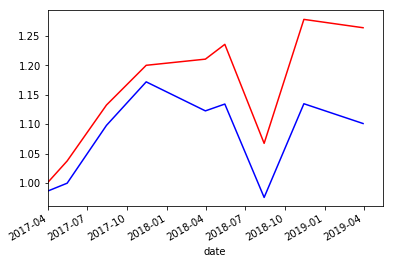

In [19]:
%matplotlib inline
returns = dataset_test['return'][prediction > 0.5]
dates = returns.index.get_level_values("date")
returns.groupby(dates).mean().cumprod().plot(color='red')

returns = dataset_test['return'][prediction < 0.5]
dates = returns.index.get_level_values("date")
returns.groupby(dates).mean().cumprod().plot(color='blue')